In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import Input
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import models, layers
import sys,os,math,pathlib
#from tensorflow.python.client import device_lib
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
#from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [ ]:
new_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/09_13/jaehee(new)ori+aug(per30)/bad'
batch_size = 32
split_percent=0.3
rand_seed=123
shuffle_num=1000

In [ ]:
data_dir = pathlib.Path(new_data_dir)
image_list = list(data_dir.glob('*/*.png'))
image_size = Image.open(image_list[0]).size
img_width=image_size[0]
img_height=image_size[1]

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent,
    subset="training",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split_percent ,
    subset="validation",
    seed=rand_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_num).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
load_model_name="aug(bad)+origin(bad)(batch=32).h5"
load_model_date="09_08"
load_model_dir='C:/Users/jaehee/Desktop/jupyter_proj/model'

test_h5 = load_model(load_model_dir+'/'+load_model_date+'/'+load_model_name)
test_h5.summary()

In [ ]:
# for layer in test_h5.layers[:-5]:
#     print(layer.name)

In [ ]:
for layer in test_h5.layers[:-1]:
    layer.trainable = False
test_h5.summary()

In [ ]:
output_layer = test_h5.layers[-1]
output_layer.output.shape

In [ ]:
transfer_model = Model(test_h5.input, output_layer(test_h5.layers[-2].output))
transfer_model.summary()

In [ ]:
transfer_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
transfer_model.summary()

In [ ]:
import time
start = time.time()
EPOCHS=150
history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)
time= time.time() - start

In [14]:
from keras.models import load_model
save_model_date="09_13"
save_model_name="bad(new(youtube_ori+aug(30))E(150)layers(_-1)))"
save_model_dir='C:/Users/jaehee/Desktop/jupyter_proj/model'
#h5 타입
transfer_model.save(save_model_dir+'/'+save_model_date+'/'+save_model_name+'.h5')
#tf 타입
transfer_model.save(save_model_dir+'/'+save_model_date+'/'+save_model_name, save_format='tf')

INFO:tensorflow:Assets written to: C:/Users/jaehee/Desktop/jupyter_proj/model/09_13/bad(new(youtube_ori+aug(30))E(150)layers(_-1)))\assets


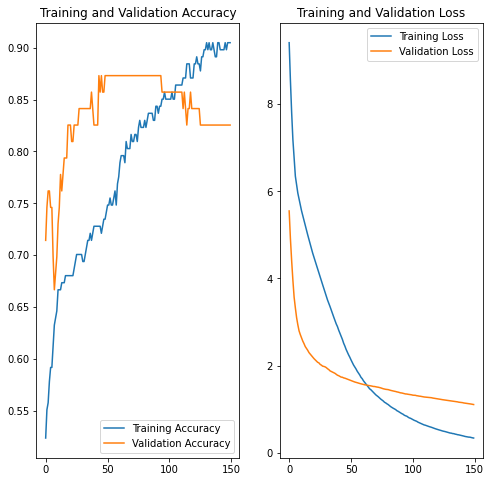

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(save_model_dir+'/'+save_model_date+'/graph/'+save_model_name+".png",bbox_inches='tight',
                pad_inches=0)

In [16]:
import sys
from keras.preprocessing import image

#pred_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/09_11/val_class(per3)/bad'
pred_data_dir='C:/Users/jaehee/Desktop/graduation_project/voice_data_files/2021_9/'+save_model_date+'/jaehee(new)_denoise(pred_20)/bad'

#file_name_list=['1.sangho_good','2.good_morning_good','3.traffic_good','4.music_good','5.today_good','6.tomorrow_good','7.youtube_good']
file_name_list=['1.sangho_bad','2.good_morning_bad','3.traffic_bad','4.music_bad','5.today_bad','6.tomorrow_bad','7.youtube_bad']

#class_name_list=['2.good_morning_bad','7.youtube_bad','1.sangho_bad','4.music_bad','3.traffic_bad','5.today_bad','6.tomorrow_bad']
#class_name_list=['1.sangho_good','2.good_morning_good','3.traffic_good','4.music_good','5.today_good','6.tomorrow_good','7.youtube_good']
class_name_list=['1.sangho_bad','2.good_morning_bad','3.traffic_bad','4.music_bad','5.today_bad','6.tomorrow_bad','7.youtube_bad']
#class_name_list=['2.good_morning','7.youtube','1.sangho','4.music','3.traffic','5.today','6.tomorrow']
txt_name = 'pred('+save_model_name+').txt'
sys.stdout = open(save_model_dir+'/'+save_model_date+'/pred_percent/'+txt_name,'w')
final=list()
for t in range(len(file_name_list)):
    #print("- - - - - - - -{}- - - - - - - -".format(file_name_list[t]))
    cnt=0.0
    max_num=20.0
    for j in range(1,21):
        image_path = pred_data_dir+'/'+class_name_list[t]+"/"+file_name_list[t]+' ('+str(j)+').png'
        img = image.load_img(image_path, target_size=(img_height, img_width))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        #print(img_array)
        predictions = transfer_model.predict(img_array)
        #print(predictions)
        score = tf.nn.softmax(predictions[0])
        #print(score)
        if(file_name_list[t]==class_names[np.argmax(score)]):
            #print("O")
            cnt+=1
        #else:
            #print("X")
        #print("{} -> {} 클래스".format(file_name_list[t],class_names[np.argmax(score)]) # 해당 클래스일 확률 , 100 * np.max(score))
    final.append(cnt/max_num*100.)
    print("{}클래스 정확도= {}%".format(file_name_list[t],final[t]))
total_avg = sum(final)/len(final)
print("총 정확도={:.2f}%".format(total_avg))
train_avg = np.mean(history.history['accuracy'])
test_avg = np.mean(history.history['val_accuracy'])
print('train_avg = {:.2f}%'.format(train_avg*100.))
print('test_avg = {:.2f}%'.format(test_avg*100.))
print("time : {:.2f}초".format(time))